### Initialize

In [67]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [68]:
import torch
from networks import MLP
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [69]:
# load_dir = '../manually_saved_runs/no_offset_ddpg_2/'
load_dir = '../manually_saved_runs/no_offset_ddpg_4/'
obs_size = 8
action_size = 2
max_action_offset = 1.0

In [70]:
device = torch.device(0)
device

device(type='cuda', index=0)

In [71]:
torch.manual_seed(3)

### Get experience buffer

In [72]:
# exp_buffer = torch.load('../manually_saved_runs/no_offset_ddpg_2/exp_buffer.pt')
exp_buffer = torch.load('../manually_saved_runs/no_offset_ddpg_4/exp_buffer.pt')
# entries are (s, a, r, s', done_flag) with |s|=8, |a|=2, |r|=1, |done_flag|=1

In [73]:
exp_buffer = torch.load(os.path.join(load_dir, "exp_buffer.pt"))
with open(os.path.join(load_dir, "exp_buffer_state.json"), "r") as fp:
    exp_buffer_state = json.load(fp)
    next_ind = exp_buffer_state["next_ind"]
    full = exp_buffer_state["full"]

In [74]:
exp_buffer

tensor([[ 0.1946,  0.1607, -0.0605,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1940,  0.1536, -0.0566,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1935,  0.1466, -0.0383,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.1970,  0.1834, -0.0771,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1962,  0.1757, -0.0767,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1954,  0.1682, -0.0736,  ...,  0.0000,  0.0000,  0.0000]])

In [75]:
# trim empty entries
exp_buffer = exp_buffer[:next_ind]
# randomly shuffle
exp_buffer = exp_buffer[torch.randperm(exp_buffer.size()[0])]

In [76]:
exp_buffer

tensor([[ 0.1734,  0.1155, -0.2063,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1789,  0.4461, -0.0349,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1615,  0.7989,  0.3443,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.2356,  0.2757, -0.1869,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2132,  0.1218,  0.0687,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2663,  0.1874,  0.1424,  ...,  0.0000,  0.0000,  0.0000]])

### Make dataset by hallucinating offsets

In [77]:
num_samples = exp_buffer.size()[0]
num_samples

949802

In [78]:
state, action, reward, next_state, done_mask = torch.split(
    exp_buffer, [obs_size, action_size, 1, obs_size, 1],
    dim=1
)

In [79]:
offsets = (torch.rand((num_samples,action_size)) - 0.5)
# above offsets are -0.5 to +0.5
offsets = offsets * max_action_offset/0.5
# now offsets are -max_action_offset to +max_action_offset

print(torch.min(offsets), torch.max(offsets))
action.size(), offsets.size()

tensor(-1.) tensor(1.0000)


(torch.Size([949802, 2]), torch.Size([949802, 2]))

In [80]:
hallucinated_actions = action - offsets
Y = offsets

In [81]:
hallucinated_buffer = torch.cat([state, hallucinated_actions, reward, next_state, done_mask], dim=1)
X = hallucinated_buffer

In [82]:
X.size(), Y.size()

(torch.Size([949802, 20]), torch.Size([949802, 2]))

### Make dataset splits

In [83]:
val_frac = 0.1
test_frac = 0.1
num_val = round(num_samples * val_frac)
num_test = round(num_samples * test_frac)
num_train = num_samples - num_val - num_test

X_train, X_val, X_test = torch.split(X, [num_train, num_val, num_test], dim=0)
Y_train, Y_val, Y_test = torch.split(Y, [num_train, num_val, num_test], dim=0)

In [84]:
print(X_train.size(), X_val.size(), X_test.size())
print(Y_train.size(), Y_val.size(), Y_test.size())

torch.Size([759842, 20]) torch.Size([94980, 20]) torch.Size([94980, 20])
torch.Size([759842, 2]) torch.Size([94980, 2]) torch.Size([94980, 2])


In [85]:
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

In [86]:
batch_size = 128
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                        shuffle=False, num_workers=num_workers)

### Train MLP

In [87]:
# model = MLP([20,64,32,2]).to(device)
model = MLP([20,256,128,64,2]).to(device)
# model = MLP([20,256,128,64,2], lambda x: 0.5 * torch.tanh(x)).to(device)

In [88]:
epochs = 10000
learning_rate = 1e-3
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# best_val_output_path = 'output/sas_to_offset_MLP_2_with_05_offset_bestval.pt'
# best_val_output_path = 'output/sas_to_offset_MLP_2_with_1_offset_bestval.pt'
best_val_output_path = 'output/sas_to_offset_MLP_4_with_1_offset_bestval.pt'

In [89]:
best_val_loss = float('inf')

for epoch in range(epochs):  # loop over the dataset multiple times
    # print(f"epoch {epoch}")

    running_train_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...
            # print(f'iter {i+1:6}  train loss: {running_train_loss/1000}')
            running_train_loss = 0.0
    
    with torch.no_grad():
        running_val_loss = 0
        num_val_batches = 0
        for i, data in enumerate(val_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            num_val_batches += 1

        val_loss = running_val_loss / num_val_batches
        # print(f"epoch {epoch} val MSE loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            print(f"epoch {epoch} val RMSE loss: {np.sqrt(val_loss):.6f} *")
            torch.save(model, best_val_output_path)
            best_val_loss = val_loss
        else:
            print(f"epoch {epoch} val RMSE loss: {np.sqrt(val_loss):.6f}")


epoch 0 val RMSE loss: 0.315851 *
epoch 1 val RMSE loss: 0.300712 *
epoch 2 val RMSE loss: 0.293997 *
epoch 3 val RMSE loss: 0.282920 *
epoch 4 val RMSE loss: 0.276958 *
epoch 5 val RMSE loss: 0.269865 *
epoch 6 val RMSE loss: 0.263158 *
epoch 7 val RMSE loss: 0.256088 *
epoch 8 val RMSE loss: 0.248331 *
epoch 9 val RMSE loss: 0.240737 *
epoch 10 val RMSE loss: 0.228493 *
epoch 11 val RMSE loss: 0.224294 *
epoch 12 val RMSE loss: 0.219074 *
epoch 13 val RMSE loss: 0.217512 *
epoch 14 val RMSE loss: 0.212345 *
epoch 15 val RMSE loss: 0.211122 *
epoch 16 val RMSE loss: 0.210094 *
epoch 17 val RMSE loss: 0.208045 *
epoch 18 val RMSE loss: 0.206797 *
epoch 19 val RMSE loss: 0.205691 *
epoch 20 val RMSE loss: 0.205745
epoch 21 val RMSE loss: 0.204239 *
epoch 22 val RMSE loss: 0.204088 *
epoch 23 val RMSE loss: 0.201364 *
epoch 24 val RMSE loss: 0.200827 *
epoch 25 val RMSE loss: 0.200441 *
epoch 26 val RMSE loss: 0.197777 *
epoch 27 val RMSE loss: 0.201612
epoch 28 val RMSE loss: 0.198069
e

KeyboardInterrupt: 

In [24]:
# output model
# output_path = 'output/sas_to_offset_MLP_1.pt'
# torch.save(model, output_path)

### Evaluate the offset MLP

In [90]:
# loaded_model = torch.load(output_path).to(device)
# loaded_model = torch.load('output/sas_to_offset_MLP_2_with_05_offset_bestval.pt').to(device)
# loaded_model = torch.load('output/sas_to_offset_MLP_2_with_1_offset_bestval.pt').to(device)
loaded_model = torch.load('output/sas_to_offset_MLP_4_with_1_offset_bestval.pt').to(device)

In [91]:
loaded_model

MLP(
  (net): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [92]:
Y_test[:10]

tensor([[ 0.3716,  0.8165],
        [-0.4940,  0.1346],
        [-0.4921,  0.4408],
        [-0.6644, -0.3482],
        [-0.4879, -0.5558],
        [ 0.2021, -0.0436],
        [-0.8599,  0.4541],
        [-0.4369, -0.2497],
        [-0.8894,  0.0325],
        [-0.1286,  0.6438]])

In [93]:
loaded_model(X_test[:10].to(device))

tensor([[ 0.5881,  0.8528],
        [-0.4625,  0.1819],
        [-0.6295,  0.5787],
        [-0.1637, -0.1903],
        [-0.6001, -0.2498],
        [ 0.5034,  0.0022],
        [-0.8201,  0.4830],
        [-0.5995, -0.1059],
        [-0.8682,  0.0378],
        [-0.0794,  0.6338]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [94]:
preds = loaded_model(X_test.to(device))
diffs = Y_test.to(device) - preds
diffs = diffs.detach().cpu()

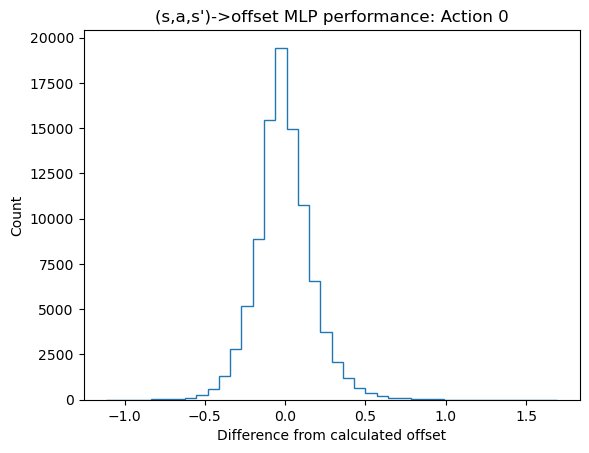

In [95]:
counts, bins = np.histogram(diffs[:,0], bins=40)
plt.stairs(counts, bins)
plt.ylabel('Count')
plt.xlabel('Difference from calculated offset')
plt.title("(s,a,s')->offset MLP performance: Action 0")
plt.show()

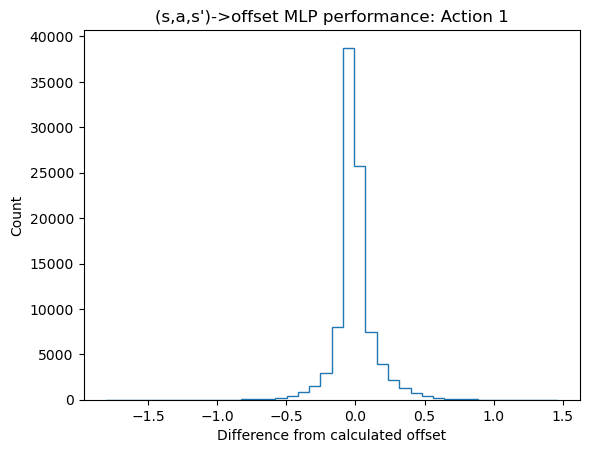

In [96]:
counts, bins = np.histogram(diffs[:,1], bins=40)
plt.stairs(counts, bins)
plt.ylabel('Count')
plt.xlabel('Difference from calculated offset')
plt.title("(s,a,s')->offset MLP performance: Action 1")
plt.show()

### Loss for different offset vals

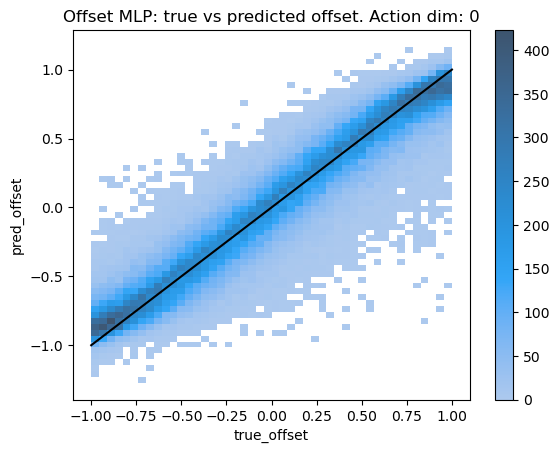

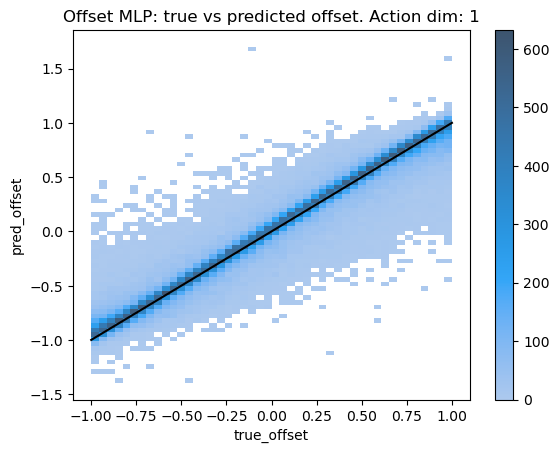

In [97]:
for i in range(2):
    df = pd.DataFrame(
        data = np.array([Y_test.numpy()[:,i],preds.detach().cpu().numpy()[:,i]]).T,
        columns = ['true_offset', 'pred_offset'],
    )

    plt.figure()
    plt.title(f'Offset MLP: true vs predicted offset. Action dim: {i}')
    sns.histplot(df, x="true_offset", y="pred_offset", cbar=True)
    plt.plot([-max_action_offset, max_action_offset], [-max_action_offset, max_action_offset], color='black')
    plt.show()

### Sanity checks

In [98]:
fake_preds = torch.zeros_like(Y_test)
# fake_preds = torch.rand_like(Y_test) - 0.5
fake_diffs = Y_test - fake_preds

In [99]:
print("Our network's test RMSE", torch.sqrt(torch.nn.functional.mse_loss(preds.detach().cpu(), Y_test)).item())
print("Fake predictions' test RMSE", torch.sqrt(torch.nn.functional.mse_loss(fake_preds, Y_test)).item())

Our network's test RMSE 0.16064022481441498
Fake predictions' test RMSE 0.5767242908477783


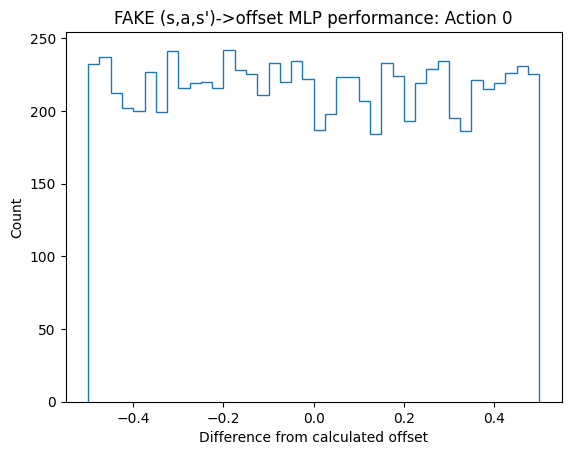

In [115]:
counts, bins = np.histogram(fake_diffs[:,0], bins=40)
plt.stairs(counts, bins)
plt.ylabel('Count')
plt.xlabel('Difference from calculated offset')
plt.title("FAKE (s,a,s')->offset MLP performance: Action 0")
plt.show()

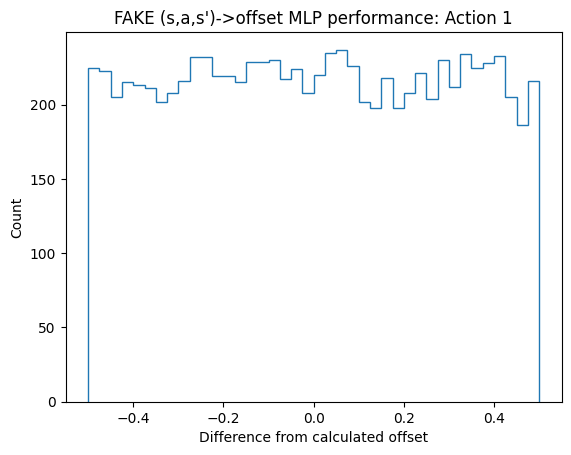

In [116]:
counts, bins = np.histogram(fake_diffs[:,1], bins=40)
plt.stairs(counts, bins)
plt.ylabel('Count')
plt.xlabel('Difference from calculated offset')
plt.title("FAKE (s,a,s')->offset MLP performance: Action 1")
plt.show()